In [10]:
import numpy as np
import torch
from torch.utils.data import Dataset
import copy
import os
import pandas as pd
import matplotlib.pyplot as plt

In [11]:
import os
import pandas as pd
import numpy as np

folder = 'inter_data'
trajs = []

root_dir = "./inter_data"
subdirectories = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]   # czj,fyy,zxm

for folder in subdirectories:
    folder_path = os.path.join(root_dir, folder)
    subfolders = [d for d in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, d))]   # czj1,czj2...
    
    for subfolder in subfolders:
        csv_files = [f for f in os.listdir(os.path.join(folder_path, subfolder)) if f.endswith('.csv')]
        
        for file in csv_files:
            file_path = os.path.join(folder_path, subfolder, file)
            df = pd.read_csv(file_path)
            x, y, phi, v = df['x'], df['y'], df['phi'], df['v']
            trajs.append(np.stack([x, y, phi, v], axis=1))


In [12]:
len(trajs)

824

(-29.767809983274205, 59.8633629500829, -36.2905800678582, 40.112099298454)

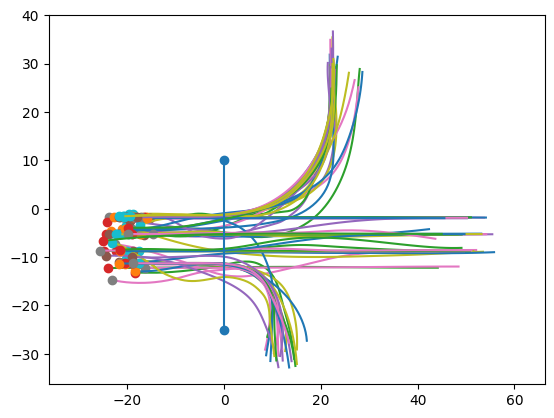

In [13]:
for i in range(100):
    plt.plot(trajs[i][:, 0], trajs[i][:, 1])
    plt.plot(trajs[i][0, 0], trajs[i][0, 1], marker='o')
    
plt.plot([0, 0], [-25, 10], marker='o')
plt.axis('equal')

In [14]:
import math

def euclidean_distance(point1, point2):
    return math.sqrt((point2[0] - point1[0])**2 + (point2[1] - point1[1])**2)


def angle_between_points(point1, point2):
    # 计算两点组成的线段的方向向量
    vector = [point2[0] - point1[0], point2[1] - point1[1]]
    # 计算方向向量与水平轴的夹角（弧度）
    angle_rad = math.atan2(vector[1], vector[0])
    # 将弧度转换为角度
    angle_deg = math.degrees(angle_rad)
    return angle_deg


data_traj_and_label = []
s, l, r = 0, 0, 0
s_data, l_data, r_data, all_data = [], [], [], {}

idx = 0
for i in range(len(trajs)):
    obs_traj = []
    fut_traj = []
    for j in range(len(trajs[i])):
        if trajs[i][j][0] <= 3:
            obs_traj.append(trajs[i][j])
        else:
            fut_traj.append(trajs[i][j])
            
    # 如果历史轨迹距离原点小于10，或者未来轨迹长度小于10，跳过
    if euclidean_distance(obs_traj[0], [0, 0]) < 10 or len(fut_traj) < 10 or len(obs_traj) < 20:  
        continue
        
    # angle_deg = angle_between_points(fut_traj[0], fut_traj[-1])
    if fut_traj[-1][1] < -20:  # 右转
        data_traj_and_label.append([np.array(obs_traj[-20:]), [0, 0, 1], idx])  
        r += 1
        r_data.append(trajs[i])
    elif fut_traj[-1][1] > 10:   # 左转
        data_traj_and_label.append([np.array(obs_traj[-20:]), [0, 1, 0], idx])   
        l += 1
        l_data.append(trajs[i])
    else:     # 直行
        data_traj_and_label.append([np.array(obs_traj[-20:]), [1, 0, 0], idx])
        s += 1
        s_data.append(trajs[i])
        
    all_data[idx] = trajs[i]
    idx += 1
    



In [15]:
print("左转数据总数", l)
print("右转数据总数", r)
print("直行数据总数", s)
print("总数", l+r+s)

左转数据总数 332
右转数据总数 188
直行数据总数 246
总数 766


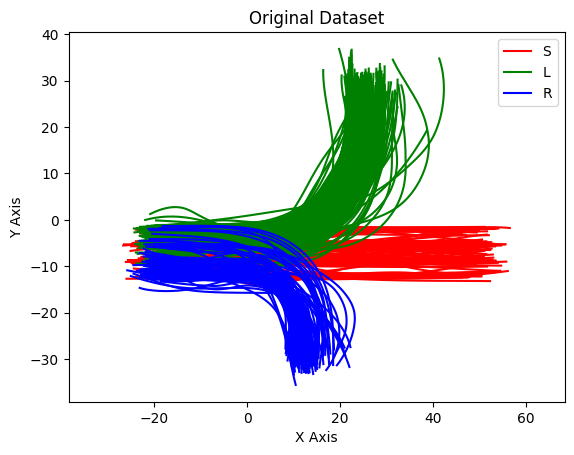

In [16]:
# 绘制 s_data 并设置标签为 'S'
for i in range(len(s_data)):
    traj = np.array(s_data[i])
    plt.plot(traj[:, 0], traj[:, 1], 'r', label='S' if i == 0 else "")

# 绘制 l_data 并设置标签为 'L'
for i in range(len(l_data)):
    traj = np.array(l_data[i])
    plt.plot(traj[:, 0], traj[:, 1], 'g', label='L' if i == 0 else "")

# 绘制 r_data 并设置标签为 'R'
for i in range(len(r_data)):
    traj = np.array(r_data[i])
    plt.plot(traj[:, 0], traj[:, 1], 'b', label='R' if i == 0 else "")

plt.axis('equal')
plt.legend()

# 设置标题和坐标轴标签
plt.title("Original Dataset")
plt.xlabel("X Axis")
plt.ylabel("Y Axis")


plt.savefig('data.png')

(-26.16630269603083, 4.387999686369209, -17.41145234665258, 2.210001787230843)

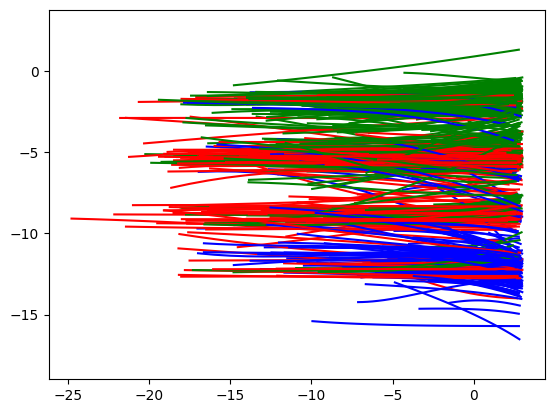

In [17]:
label_colors = {'[1, 0, 0]': 'red', '[0, 0, 1]': 'blue', '[0, 1, 0]': 'green'}

for i in range(len(data_traj_and_label)):
    traj = data_traj_and_label[i][0]
    label = data_traj_and_label[i][1]
    
    color = label_colors.get(str(label), 'black')
    plt.plot(traj[:, 0], traj[:, 1], color=color)
    

plt.axis('equal')

In [18]:
import pickle
# 存储为 Pickle 文件
with open('data_traj_and_label.pkl', 'wb') as file:
    pickle.dump(data_traj_and_label, file)
    
with open('all_data.pkl', 'wb') as file:
    pickle.dump(all_data, file)